In [1]:
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
from datetime import datetime
from typing import Optional, TextIO
from functools import partial
import sys

In [2]:
DEVICE = torch.device("cpu") # No point in using MPS for now :( See https://github.com/pytorch/pytorch/issues/77799

## NN Utilities

In [3]:
def run_single_epoch(loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class = 1, train=True):
    '''
    A single epoch for the training / validation loop.
    
    Returns: A tuple of (model, optimizer, avg_batch_loss_for_epoch)
    '''        
    
    model.train() if train else model.eval() 
    
    running_loss = 0
    
    # TODO create a conditional "with" block for torch.no_grad (the loop should be inside)
    
    # Each iteration gets a batch from the loader
    for X, Y_true in loader:
        X = normalize_input_fn(X) # Normalizing the input if necessary
        X = X.to(DEVICE)
        Y_true = normalize_labels_fn(Y_true)
        Y_true = Y_true.to(DEVICE)
        # Y_true[Y_true == positive_class]  = 1 # We "normalize" the label of the positive class to be "1". Makes our lives easier (see comment below)
        
        optimizer.zero_grad() if train else None
        
        # Forward pass
        Y_logits, Y_prob = model(X)
        _, predicted_labels = torch.max(Y_prob, 1)  # The "1" is acutally misleading - it's the dimension to search the max in.
                                                        # This actually returns the indices of the highest prediction for each row, 
                                                        # but since the index is one-to-one with the predicted digit (i.e., 0 or 1), 
                                                        # we use the index of the max probability as the label that's being predicted
        batch_loss = criterion(Y_logits, Y_true) # we use the logits as the parameter since "CELoss already pefroms softmax internally.
        running_loss += batch_loss.item() * X.size(0) # X.size(0) is the size of the BATCH, not the image. 
                                                # The multiplication is required later for calculating the avg loss of the epoch step.
        
        # Backward pass, only required in training the model
        if train:
            batch_loss.backward()
            optimizer.step()
    
    avg_batch_loss_for_epoch = running_loss / len(loader.dataset)
    return model, optimizer, avg_batch_loss_for_epoch

In [4]:
def display_and_save_images(images_set, n=4, label="", count=False):
    plt.figure(figsize=(18, 4))
    plt.suptitle(label, color='black', fontsize=16)
    for i in range(n):
        pic = images_set[i][0].data.cpu().view(-1, 32, 32)
        plt.subplot(1,n,i+1)
        plt.imshow(pic[0]) # This line of code is a problem if the last batch has less than 4 images
        plt.axis('off')
    plt.savefig(F"{label}.png")

In [5]:
def run_loop(train_loader, validation_loader, criterion, model, optimizer, positive_class=1, num_epochs=10, normalize_input_fn=lambda x: x, 
             normalize_labels_fn=lambda y: y, print_every=1):
    
    # Objects for storing metrics
    best_loss = 1e10
    train_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        # print(f'Epoch: {epoch}\t')
        
        # Training the model
        _, _, train_loss = run_single_epoch(train_loader, criterion, model, optimizer, normalize_input_fn, normalize_labels_fn, positive_class)
        train_losses.append(train_loss)
        
        # No need for validation when working with a score model
        validation_losses.append(0)
        # # Validation
        # with torch.no_grad():
        #     _, _, validation_loss = run_single_epoch(validation_loader, criterion, model, None, normalize_input_fn, normalize_labels_fn, positive_class, False)
        #     validation_losses.append(validation_loss)
        
        # if epoch % print_every == (print_every - 1):
        #     print(f'{datetime.now().time().replace(microsecond=0)} --- '
        #           f'Epoch: {epoch}\t'
        #           f'Train loss: {train_loss:.4f}\t'
        #           # f'Vaildation loss: {validation_loss:.4f}\t')
        #           f'Vaildation loss: 0\t')
        
    return model, optimizer, num_epochs, (train_losses, validation_losses)

### Models

In [6]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probabilities = F.softmax(logits, dim=1)
        return logits, probabilities


In [7]:
class SimpleDataSet(Dataset):
    def __init__(self, data, targets):
        super(SimpleDataSet, self).__init__()
        assert data.shape[0] == targets.shape[0] # assuming shape[0] = dataset size
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.targets[index].item()

In [8]:
class EncodeBasedLikelihoodRatioModel():
    def __init__(self, vae, null_mv, positive_mv):
        self.vae = vae
        self.null_mv = null_mv
        self.positive_mv = positive_mv
    
    def __call__(self, value):
        mu_logvar = self.vae.encoder(value.view(-1, 1024)).view(-1, 2, LATENT_DIM)
        mu = mu_logvar[:, 0, :]
        llr = self.positive_mv.log_prob(mu) - self.null_mv.log_prob(mu)
        # We need a 0s "column as the first col to represent the probability of the "null" class (same as LeNet result)
        llr_0_padded_right = torch.stack((torch.zeros(llr.view(-1,1).shape[0]).view(-1,1),llr.view(-1,1)), dim=1).squeeze()
        return None, llr_0_padded_right
    
    def eval(self):
        pass

class LikelihoodRatioModel():
    def __init__(self, null_mv, positive_mv):
        self.null_mv = null_mv
        self.positive_mv = positive_mv
    
    def __call__(self, value):
        llr = self.positive_mv.log_prob(value) - self.null_mv.log_prob(value)
        # We need a 0s "column as the first col to represent the probability of the "null" class (same as LeNet result)
        llr_0_padded_right = torch.stack((torch.zeros(llr.view(-1,1).shape[0]).view(-1,1),llr.view(-1,1)), dim=1).squeeze()
        return None, llr_0_padded_right
    
    def eval(self):
        pass

## Samples Generation

In [9]:
LATENT_DIM = 5

class VAEFC(nn.Module):
    '''
    A fully-connected variational autoencoder (as opposed to convolution-based) used as generative model for MNIST.
    '''

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1024, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, LATENT_DIM * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, 400),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 1024),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 1024)).view(-1, 2, LATENT_DIM)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

In [10]:
def vae_loss_for_single_element_batch(x_hat, x, mu, logvar, y=None, β=3, null_label=4):
    '''
    'Dynamic' loss: this function changes based on the type of MNIST digit. This forces the VAE to place each digit near the mean we want, effectively
    creating a mixture model of normals.

    IMPORTANT: THIS WILL ONLY WORK WITH BATCH_SIZE=1 because otherwise the loss will be averaged, requiring a lot more epochs to get the means we want.
    '''
    base_loss = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 1024), reduction='sum'
    )
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2)) # Orig KLD
    
    # KLD(p,q) = KL(N(m1,s1), N(m2,s2)) = log(std2/std1) + (s1 + ((m1-m2)^2))/(2*s2) - 1/2    , where s is VARIANCE (not STD), std1=sqrt(s1)
    KLD = 0
    if y[0]==null_label:
        KLD = 0.5 * torch.sum(logvar.exp() - logvar + (mu-1).pow(2) -1)
    else:
        KLD = 0.5 * torch.sum(logvar.exp() - logvar + (mu+1).pow(2) -1)
    return base_loss + β * KLD

def standard_vae_loss(x_hat, x, mu, logvar, y=None, β=1):
    '''
    Basic VAE binary-cross-entropy loss, averaging over the mini-batch.
    '''
    base_loss = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 1024), reduction='sum'
    )
    
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return base_loss + β * KLD

In [11]:
# Define data loading step

class_map = {"null": 4, "positive": 9}
labels_map = {4:0, 9:1} 

def get_loader_for_vae(dataset, class_to_load=None, batch_size=1, num_samples=None):
    if class_to_load is None:
        samples_index = torch.logical_or(dataset.targets == class_map["null"] ,dataset.targets == class_map["positive"]).nonzero().reshape(-1)
    else:
        samples_index = (dataset.targets == class_map[class_to_load]).nonzero().reshape(-1)
    if num_samples is not None:
        samples_index = samples_index[:num_samples]
    print(F"sample index: {samples_index.shape}")
    return DataLoader(dataset,batch_size=batch_size, shuffle=False, sampler=SubsetRandomSampler(samples_index), drop_last=True)

In [12]:
def train_VAE(vae, train_loader, vae_criterion, epochs=10):
    
    learning_rate = 1e-3
    
    vae_optimizer = torch.optim.Adam(
        vae.parameters(),
        lr=learning_rate,
    )
    
    for epoch in range(epochs):
        vae.train()
        train_loss = 0
        print(f'====> VAE Epoch: {epoch}')
        for x, label in train_loader:
            x = x.to(DEVICE)
            # ===================forward=====================
            x_hat, mu, logvar = vae(x)
            loss = vae_criterion(x_hat, x, mu, logvar, label)
            train_loss += loss.item()
            # ===================backward====================
            vae_optimizer.zero_grad()
            loss.backward()
            vae_optimizer.step()
        # ===================log========================
        print(f'VAE Average loss: {train_loss / len(train_loader.dataset):.4f}')
    return vae, vae_optimizer, epochs

In [13]:
from typing import TypedDict

VAECodes = TypedDict('VAECodes', {'mu': torch.Tensor, 'logvar': torch.Tensor, 'label': torch.Tensor})

def get_VAE_codes_for_samples(vae: torch.nn.Module, loader: torch.utils.data.DataLoader) -> VAECodes: 
    codes = dict(mu=list(), logvar=list(), label=list())
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        vae.eval()
        for x, y in loader:
            x = x.to(DEVICE)
            # ===================forward=====================
            x_hat, mu, logvar = vae(x)
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'] = torch.cat(means)
    codes['logvar']= torch.cat(logvars)
    codes['label'] = torch.cat(labels)
    return codes

In [14]:
def get_mean_and_vcov_for_vae_codes(codes: VAECodes):
        mean_tensor = codes['mu'].mean(0)
        centered_mus = codes['mu'] - mean_tensor
        vcov = centered_mus.T.cov()
        return dict(mean=mean_tensor, vcov=vcov, centered_mus=centered_mus)

In [15]:
def plot_codes_hist(codes, description="", dim=5):
    fig, axes = plt.subplots(nrows=1, ncols=dim, figsize=(16,4))
    fig.suptitle(description)
    for i in range(dim):
        ax = axes[i]
        ax.hist(codes[:,i].numpy(), 20)
    fig.show()
    if description!="":
        fig.savefig(F"{description}-hist.png")

In [16]:
VAEResult = TypedDict('VAEResult', {'vae': torch.nn.Module, 'null_mean': torch.Tensor, 'positive_mean':torch.Tensor, 'common_vcov': torch.Tensor})

image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

def get_trained_vae() -> torch.nn.Module:
    '''
    Returns: an MNIST-trained VAE.
    '''
    # Loading relevant data
    train_all_loader = get_loader_for_vae(MNIST('./data', train=True, download=True, transform=image_padding_to_32))

    # Create and train the VAE
    vae = VAEFC().to(DEVICE)
    vae, vae_optimizer, vae_num_epochs = train_VAE(vae, train_all_loader, vae_loss_for_single_element_batch)
    
    return vae, vae_optimizer, vae_num_epochs 


def get_vae_stats(vae: torch.nn.Module, null_loader:Optional[torch.utils.data.DataLoader]=None, positive_loader:Optional[torch.utils.data.DataLoader]=None, description:Optional[str]=""):
    '''
    Parameters:
        vae: The MNIST-trained VAE to get the stats from.
    
    Returns:
        a Dictionary of the form: {null_mean: torch.Tensor, positive_mean: torch.Tensor, common_vcov: torch.Tensor} 
    '''
    
    null_stats = dict(mean=None, vcov=None, centered_mus=None)
    if null_loader:
        null_codes = get_VAE_codes_for_samples(vae, null_loader)
        null_stats = get_mean_and_vcov_for_vae_codes(null_codes)
        if description!="":
            plot_codes_hist(null_codes['mu'], F"{description}-null-class")
        
    positive_stats = dict(mean=None, vcov=None, centered_mus=None)
    if positive_loader:
        positive_codes = get_VAE_codes_for_samples(vae, positive_loader)
        positive_stats = get_mean_and_vcov_for_vae_codes(positive_codes)
        if description!="":
            plot_codes_hist(positive_codes['mu'], F"{description}-positive-class")
        
    # calculate common vcov matrix (we want this so that the likelihood ratio will translate to LDA).
    common_vcov = None
    if null_loader and positive_loader:
        all_centered_means = torch.cat((null_stats['centered_mus'], positive_stats['centered_mus']))
        common_vcov= all_centered_means.T.cov()
    
    return dict(null_mean=null_stats['mean'], null_vcov=null_stats['vcov'], positive_mean=positive_stats['mean'], positive_vcov=positive_stats['vcov'],
                common_vcov=common_vcov, null_centered_means=null_stats['centered_mus'], positive_centered_means=positive_stats['centered_mus'])

    
def get_trained_vae_and_stats(description:Optional[str]="") -> VAEResult:
    vae, vae_optimizer, vae_num_epochs = get_trained_vae()
    
    # Loading relevant data
    train_null_only = get_loader_for_vae(MNIST('./data', train=True, download=True, transform=image_padding_to_32), class_to_load="null")
    train_positive_only = get_loader_for_vae(MNIST('./data', train=True, download=True, transform=image_padding_to_32), class_to_load="positive")
    
    stats = get_vae_stats(vae, train_null_only, train_positive_only, description)
    return vae, vae_optimizer, vae_num_epochs, stats['null_mean'], stats['positive_mean'], stats['common_vcov']

In [17]:
def get_generated_datasets_from_vae(vae: torch.nn.Module, null_mv: torch.distributions.MultivariateNormal, positive_mv: torch.distributions.MultivariateNormal):
    
    TRAINING_SIZE = random.randint(4000,6000)
    TEST_NULL_SIZE = random.randint(500,2000)
    TEST_POSITIVE_SIZE = random.randint(500,2000)
    BENCHMARK_NULL_SIZE = math.floor(TRAINING_SIZE / 2)
    BENCHMARK_POSITIVE_SIZE = math.floor(TRAINING_SIZE / 2)
    with torch.no_grad():
        vae.eval()
        
        # Training set (only 4s)
        training_codes = null_mv.sample(torch.Size([TRAINING_SIZE]))
        training_data = vae.decoder(training_codes).unsqueeze(dim=1).view(-1,1,32,32)
        training_targets = torch.repeat_interleave(torch.tensor([0]), TRAINING_SIZE)
        training_set = SimpleDataSet(training_data, training_targets)

        # Benchmark set (4 and 9s)
        benchmark_null_codes = null_mv.sample(torch.Size([BENCHMARK_NULL_SIZE]))
        benchmark_positive_codes = positive_mv.sample(torch.Size([BENCHMARK_POSITIVE_SIZE]))
        benchmark_codes = torch.cat((benchmark_null_codes, benchmark_positive_codes)) 
        benchmark_null_targets = torch.repeat_interleave(torch.tensor([0]), BENCHMARK_NULL_SIZE)
        benchmark_positive_targets = torch.repeat_interleave(torch.tensor([1]), BENCHMARK_POSITIVE_SIZE)
        benchmark_targets = torch.cat((benchmark_null_targets, benchmark_positive_targets)) 
        shuffle = torch.randperm(BENCHMARK_NULL_SIZE + BENCHMARK_POSITIVE_SIZE) # we want mixed, random-ordered samples
        benchmark_codes = benchmark_codes[shuffle]
        benchmark_targets = benchmark_targets[shuffle]
        benchmark_data = vae.decoder(benchmark_codes).unsqueeze(dim=1).view(-1,1,32,32)
        benchmark_set = SimpleDataSet(benchmark_data, benchmark_targets)


        # Test set (4 and 9s)
        test_null_codes = null_mv.sample(torch.Size([TEST_NULL_SIZE]))
        test_positive_codes = positive_mv.sample(torch.Size([TEST_POSITIVE_SIZE]))
        test_codes = torch.cat((test_null_codes, test_positive_codes)) 
        test_null_targets = torch.repeat_interleave(torch.tensor([0]), TEST_NULL_SIZE)
        test_positive_targets = torch.repeat_interleave(torch.tensor([1]), TEST_POSITIVE_SIZE)
        test_targets = torch.cat((test_null_targets, test_positive_targets)) 
        shuffle = torch.randperm(TEST_NULL_SIZE + TEST_POSITIVE_SIZE) # we want mixed, random-ordered samples
        test_codes = test_codes[shuffle]
        test_targets = test_targets[shuffle]
        test_data = vae.decoder(test_codes).unsqueeze(dim=1).view(-1,1,32,32)
        test_set = SimpleDataSet(test_data, test_targets)

        return training_set, test_set, benchmark_set, training_codes, test_codes, benchmark_codes, TEST_POSITIVE_SIZE

### Training

In [18]:
def get_trained_model(train_loader, test_loader, num_epochs=20):
    LEARNING_RATE = 1e-3
    N_CLASSES = 2
    
    model = nn.DataParallel(LeNet5(N_CLASSES)) # We create the model from scratch for each experiment
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    return run_loop(train_loader, test_loader, criterion, model, optimizer, normalize_input_fn=lambda x: x / 255.0, num_epochs=num_epochs)

In [19]:
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, datasetA, datasetB):
        super(ConcatDataset, self).__init__()
        self.datasetA = datasetA
        self.datasetB = datasetB

    def __getitem__(self, i):
        if i<len(self.datasetA):
            return self.datasetA[i]
        else:
            return self.datasetB[i-len(self.datasetA)]

    def __len__(self):
        return (len(self.datasetA) + len(self.datasetB))

In [20]:
import copy

def clone_and_new_computation_graph(t: torch.Tensor, requires_grad=True) -> torch.Tensor:
    '''
        Returns: 
            A Tensor with the same data (copied) as `t`, on a new computation graph
    '''
    t2 = torch.detach(t).clone()
    if requires_grad:
        t2.requires_grad_()
    return t2


def get_synthetic_h0_h1(training_set: SimpleDataSet, test_set: SimpleDataSet, training_codes: torch.Tensor, test_codes: torch.Tensor) -> tuple[SimpleDataSet, SimpleDataSet, SimpleDataSet, int, Optional[torch.Tensor], Optional[torch.Tensor]]:
    '''
    Parameters:
        Training and Test datasets. Each of the following form:
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    Returns:
        H0, H1, H1 with true target values (used for validation), K
    '''
    
    k = len(training_set)- len(test_set) 
    k = k if (k > 500) else math.floor(len(training_set) / 3) # The original value of K might be very small, so w
    original_training_data = training_set.data
    original_training_targets = training_set.targets

    # Create H0 set by *copying* the training set, and have it use a separate computation graph.
    h0_data = clone_and_new_computation_graph(original_training_data[:k])
    h0_codes = training_codes[:k] if training_codes is not None else None
    h0_targets = clone_and_new_computation_graph(original_training_targets[:k], requires_grad=False)
    h0_targets[:] = 0

    h0_set = SimpleDataSet(h0_data, h0_targets)
    
    # Create H1 and H1_true_targets sets by *copying* the data and have it use a separate computation graph
    h1_0_data = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_codes = training_codes[k:] if training_codes is not None else None
    h1_0_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    h1_0_targets[:] = 1
        
    h1_0_data_for_true_targets = clone_and_new_computation_graph(original_training_data[k:])
    h1_0_true_targets = clone_and_new_computation_graph(original_training_targets[k:], requires_grad=False)
    
    original_test_data = test_set.data
    original_test_targets = test_set.targets
    h1_1_data = clone_and_new_computation_graph(original_test_data)
    h1_1_codes = test_codes if test_codes is not None else None
    h1_1_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    h1_1_targets[:] = 1
    
    h1_1_data_for_true_targets = clone_and_new_computation_graph(original_test_data)
    h1_1_true_targets = clone_and_new_computation_graph(original_test_targets, requires_grad=False)
    
    h1_data = torch.cat((h1_0_data, h1_1_data), 0)
    h1_codes = torch.cat((h1_0_codes, h1_1_codes)) if test_codes is not None else None
    h1_targets = torch.cat((h1_0_targets, h1_1_targets), 0)
    
    h1_set = SimpleDataSet(h1_data, h1_targets)
    
    h1_data_true = torch.cat((h1_0_data_for_true_targets, h1_1_data_for_true_targets), 0)
    h1_targets_true = torch.cat((h1_0_true_targets, h1_1_true_targets), 0)
    
    h1_set_with_true_targets = SimpleDataSet(h1_data_true, h1_targets_true)
    

    return h0_set, h1_set, h1_set_with_true_targets, k, h0_codes, h1_codes

In [21]:
def get_datasets_for_discovery(experiment_type: int, add_noise=False) -> tuple[SimpleDataSet, SimpleDataSet]:
    '''
    Parameters:
        experiment_type:
            1 - test data is only H1, no noise
            2 - test data is a mix of H0 and H1, no noise
            
    Returns:
        A Tuple of (training_set, test_set, benchmark_set)
            Dataset.data: 4-D tensor (batch size, channels, width, height). This is because nn.Conv2d expects input of this shape.
            Dataset.targets: 1-D tensor (target class)
    '''
    
    BENCHMARK_TRAINING_SIZE = 1000 # data used for training a *standard* classifier for benchmark purposes
    
    image_padding_to_32 = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
    
    if add_noise:
        raise NotImplementedError("Adding noise was not yet implemented")
        
    ## Training data
    training_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=True)
    training_subset_index = (training_set_full.targets == 4).nonzero().reshape(-1)
    training_subset_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(training_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(training_subset_index))
    training_subset_data, training_subset_targets = next(iter(training_subset_loader)) # We only need one iteration, as the loader has the size of the entire relevant sample

    assert len(training_subset_targets[(training_subset_targets!=4).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    
    training_subset_targets[(training_subset_targets==4).nonzero().reshape(-1)] = 0  # Set the targets' value to 0 (as this is our "null" class).

    # Separating training for Adadetect and benchmark
    benchmark_four_subset_data = training_subset_data[-BENCHMARK_TRAINING_SIZE:]
    benchmark_four_subset_targets = training_subset_targets[-BENCHMARK_TRAINING_SIZE:]
    
    # Notice that since we update training_subset_data itself, this MUST happen AFTER we already got the benchmark data.
    training_subset_data = training_subset_data[:-BENCHMARK_TRAINING_SIZE]
    training_subset_targets = training_subset_targets[:-BENCHMARK_TRAINING_SIZE]
    
    benchmark_nine_subset_index = (training_set_full.targets == 9).nonzero().reshape(-1)
    benchmark_nine_subset_loader = torch.utils.data.DataLoader(dataset=training_set_full, batch_size=len(benchmark_nine_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(benchmark_nine_subset_index))
    benchmark_nine_subset_data, benchmark_nine_subset_targets = next(iter(benchmark_nine_subset_loader)) 
    
    assert len(benchmark_nine_subset_targets[(benchmark_nine_subset_targets!=9).nonzero().reshape(-1)])==0 # Avoid bugs in data loading. You're welcome hahaha
    
    benchmark_nine_subset_targets[(benchmark_nine_subset_targets==9).nonzero().reshape(-1)] = 1  # Set the targets' value to 1 (as this is our "positive" class).
    
    benchmark_data = torch.cat([benchmark_four_subset_data, benchmark_nine_subset_data], dim=0)
    benchmark_targets = torch.cat([benchmark_four_subset_targets,benchmark_nine_subset_targets], dim=0)
    benchmark_set = SimpleDataSet(benchmark_data, benchmark_targets)
    
    training_set = SimpleDataSet(training_subset_data, training_subset_targets)
    
    ## Test data
    test_set_full = datasets.MNIST(root='./data', download=True, transform=image_padding_to_32, train=False)
    test_subset_index = []
    if experiment_type==1:
        test_subset_index = (test_set_full.targets == 9).nonzero().reshape(-1)
    elif experiment_type==2:
        test_subset_index = torch.logical_or(test_set_full.targets == 4, test_set_full.targets == 9).nonzero().reshape(-1)
    else:
        raise NotImplementedError("Only 1,2 experiment types are supported")
    
    test_subset_loader = torch.utils.data.DataLoader(dataset=test_set_full, batch_size=len(test_subset_index), shuffle=False, sampler=Data.SubsetRandomSampler(test_subset_index))
    test_subset_data, test_subset_targets = next(iter(test_subset_loader))
    test_subset_targets[(test_subset_targets==4).nonzero().reshape(-1)] = 0
    test_subset_targets[(test_subset_targets==9).nonzero().reshape(-1)] = 1
    test_set = SimpleDataSet(test_subset_data, test_subset_targets)
    
    return training_set, test_set, benchmark_set, None, None, None

In [22]:
def perform_knockoffs(score_model, h1_set, h1_set_with_true_targets, l, m, alpha):
    with torch.no_grad():
        score_model.eval()
        _, probability_scores = score_model(h1_set.data.to(DEVICE)) # probability scores is a tensor of pairs (p(0), p(1)).
    probability_of_discovery = probability_scores[:,1].numpy() # We only care about the probability of a discovery (p(1))

    print(F"probability scores: {probability_scores}")
    print(F"probability of discovery: {probability_of_discovery}")
    print(F"PoD shape: {probability_of_discovery.shape}, l+m: {l+m}, truth: {h1_set_with_true_targets.targets.shape}")
    scores_df = pd.DataFrame({'score': probability_of_discovery, 'is_test': np.concatenate((np.repeat(0, l),np.repeat(1,m))),'truth':h1_set_with_true_targets.targets.numpy()})
    scores_df.sort_values(by=['score'], inplace=True, ascending=True)
    
    fdp = 10 # a value which is definitely bigger than alpha
    
    for lower_bound in range(len(h1_set)):
        scores_window_df = scores_df[lower_bound:] # get the subset of the samples we want to test with.
        ktest = len(scores_window_df[scores_window_df['is_test']==1]) # This is the "moving" k, which changes as we move the lower score bound.
        v = len(scores_window_df[scores_window_df['is_test']==0]) # The count of false discoveries that we know of (i.e., training samples)
        try: 
            fdp = ((v+1) / (l+1)) * (m / ktest)
        except ZeroDivisionError:
            fdp = 99999
            break
        # print(F"ktest: {ktest},\t"
        #       F"v: {v},\t"
        #       F"m: {m},\t"
        #       F"l: {l},\t"
        #       F"fdp: {fdp}")

        if fdp<=alpha:
            # print(F"Got FDP of {fdp} <= alpha({alpha}) , for lower bound: {lower_bound}")
            break
    
    total_elements = len(scores_window_df)
    total_discoveries = ktest
    false_discoveries = len(scores_window_df[(scores_window_df['is_test']==1) & (scores_window_df['truth']==0)])
    
    return dict(total_elements=total_elements, total_discoveries=total_discoveries,false_discoveries=false_discoveries,v=v,fdp=fdp, scores_df=scores_df, lower_bound=lower_bound)

In [23]:
def plot_tsne_clouds(experiment_id, tsne_codes, Y):
    fig,ax = plt.subplots()
    s = plt.scatter(tsne_codes[:,0], tsne_codes[:,1], c=Y, cmap='tab10')
    plt.grid(False)
    plt.title(f'Experiment: {experiment_id}')
    plt.axis('equal')
    plt.savefig(F"{experiment_id}-tsne-clouds.png")

In [24]:
def run_discovery(seed, batch_size, experiment_type, experiment_id, alpha=0.1, use_generative=True):
    
    # Reproducability :-)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create an image generating VAE based on MNIST data, and respective multivariate normals for VAE codes.
    if use_generative:
        generator_vae, generator_vae_optimizer, generator_vae_num_epochs, null_mean, positive_mean, vcov = get_trained_vae_and_stats(F"{experiment_id}-generator-vae")
        generator_null_mv, generator_positive_mv = MultivariateNormal(null_mean, vcov), MultivariateNormal(positive_mean, vcov)
    
    # Get the data (notice this generates/loads in a different random order each time, given the seed)
    training_set, test_set, supervised_training_set, training_codes, test_codes, supervised_training_codes, test_positive_size = get_generated_datasets_from_vae(generator_vae, generator_null_mv, generator_positive_mv) if use_generative else get_datasets_for_discovery(experiment_type)
    
    # Reproducability :-)
    np.savetxt(F"{experiment_id}-training-codes.csv", training_codes.numpy(), delimiter=',', fmt="%f")
    np.savetxt(F"{experiment_id}-test-codes.csv", test_codes.numpy(), delimiter=',', fmt="%f")
    np.savetxt(F"{experiment_id}-supervised-codes.csv", supervised_training_codes.numpy(), delimiter=',', fmt="%f")
    
    # Some images for sample
    display_and_save_images(training_set, label=F"{experiment_id}-generated-training-set-sample")
    display_and_save_images(test_set, label=F"{experiment_id}-generated-test-set-sample")
    display_and_save_images(supervised_training_set, label=F"{experiment_id}-generated-supervised-training-set-sample")
    
    # Re-divide train and test data for AdaDetect
    h0_set, h1_set, h1_set_with_true_targets, k, generator_h0_codes, generator_h1_codes = get_synthetic_h0_h1(training_set, test_set, training_codes, test_codes)
    h0h1_set = ConcatDataset(h0_set,h1_set)
    
    # Reproducability :-)
    np.savetxt(F"{experiment_id}-generator-h1-codes.csv", generator_h1_codes.numpy(), delimiter=',', fmt="%f")
    
    # Wrap datasets in loaders for training/test.
    h0h1_loader = DataLoader(h0h1_set, batch_size=batch_size, shuffle=True)
    supervised_training_loader = DataLoader(supervised_training_set, shuffle=True)

    ## Use BoNuS and Knockoff counting for stating discoveries while keeping FDR
    l = len(training_set)-k # This is the length of the "2nd part" of the null samples, which is concatenated to the test sample
    m = len(test_set)
    
    # Training
    adadetect_model, ad_optimizer, ad_num_epochs, (ad_train_losses, ad_validation_losses) = get_trained_model(h0h1_loader, None, num_epochs=100)
    supervised_cnn_model, sc_optimizer, sc_num_epochs, (sc_train_losses, sc_validation_losses) = get_trained_model(supervised_training_loader, None, num_epochs=20)
    
    # VAE based classification
    if use_generative:
        adadetect_vae = VAEFC().to(DEVICE)
        # Train the VAE on EVERYTHING.
        h1_loader = DataLoader(h1_set, batch_size=len(h1_set),shuffle=False)
        adadetect_vae, adadetect_vae_optimizer, adadetect_vae_num_epochs = train_VAE(adadetect_vae, h0h1_loader, standard_vae_loss)
        # Get VAE stats for the positive class
        adadetect_vae_h1_stats = get_vae_stats(adadetect_vae, None, h1_loader, description=F"{experiment_id}-vae-adadetect")
        adadetect_vae_h1_mean = adadetect_vae_h1_stats['positive_mean']
        h1_codes = adadetect_vae_h1_stats['positive_centered_means'] + adadetect_vae_h1_mean
        # Perform TSNE on the codes for h1. This should provide a two-cloud structure
        E = TSNE(n_components=2).fit_transform(h1_codes.detach().cpu())
        # Reproducability :-)
        np.savetxt(F"{experiment_id}-tsne-codes.csv", E, delimiter=',', fmt="%f")
        plot_tsne_clouds(experiment_id, E, h1_set_with_true_targets.targets.numpy())
        # We'll use K-Means algorithm to find the two-cloud structure created by TSNE
        kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(E)
        mus2 = kmeans.cluster_centers_
        # We "assume" a common variance, normal distribution of the codes using TSNE, but we can also use KDE for example, to get the clouds' distribution.
        common_vcov = torch.diag(torch.repeat_interleave(torch.tensor(math.sqrt(kmeans.inertia_ / len(E))),2))
        adadetect_vae_mv_1 = MultivariateNormal(torch.from_numpy(mus2[0]), common_vcov)
        adadetect_vae_mv_2 = MultivariateNormal(torch.from_numpy(mus2[1]), common_vcov)
    
    # Knockoff Process
    adadetect_knockoff_results = perform_knockoffs(adadetect_model, h1_set, h1_set_with_true_targets, l, m, alpha)
    adadetect_knockoff_results['scores_df'].to_csv(F"{experiment_id}-adadetect-scores.csv", encoding='utf-8')
    
    supervised_cnn_knockoff_results = perform_knockoffs(supervised_cnn_model, h1_set, h1_set_with_true_targets, l, m, alpha)
    supervised_cnn_knockoff_results['scores_df'].to_csv(F"{experiment_id}-supervised-cnn-scores.csv", encoding='utf-8')
    
    benchmark_lr_model = LikelihoodRatioModel(generator_null_mv, generator_positive_mv) if use_generative else None
    benchmark_lr_knockoff_results = perform_knockoffs(benchmark_lr_model, generator_h1_codes, h1_set_with_true_targets, l, m, alpha) if use_generative else dict(total_elements=-1, total_discoveries=-1, false_discoveries=-1,v=-1,fdp=-1)
    benchmark_lr_knockoff_results['scores_df'].to_csv(F"{experiment_id}-benchmark-lr-scores.csv", encoding='utf-8')
    
    vae_adadetect_lr_model_1 = LikelihoodRatioModel(adadetect_vae_mv_1, adadetect_vae_mv_2) if use_generative else None
    vae_adadetect_lr_knockoff_results_1 = perform_knockoffs(vae_adadetect_lr_model_1, torch.from_numpy(E), h1_set_with_true_targets, l, m, alpha) if use_generative else dict(total_elements=-1, total_discoveries=-1, false_discoveries=-1,v=-1,fdp=-1)
    print(F"vae_adadetect_lr_knockoff_results_1: {vae_adadetect_lr_knockoff_results_1}")
    
    vae_adadetect_lr_model_2 = LikelihoodRatioModel(adadetect_vae_mv_2, adadetect_vae_mv_1) if use_generative else None
    vae_adadetect_lr_knockoff_results_2 = perform_knockoffs(vae_adadetect_lr_model_2, torch.from_numpy(E), h1_set_with_true_targets, l, m, alpha) if use_generative else dict(total_elements=-1, total_discoveries=-1, false_discoveries=-1,v=-1,fdp=-1)
    print(F"vae_adadetect_lr_knockoff_results_2: {vae_adadetect_lr_knockoff_results_2}")
    
    winner_vae_adadetect_lr_model, winner_vae_adadetect_lr_knockoff_results = (vae_adadetect_lr_model_1, vae_adadetect_lr_knockoff_results_1) if vae_adadetect_lr_knockoff_results_1['total_discoveries'] > vae_adadetect_lr_knockoff_results_2['total_discoveries'] else (vae_adadetect_lr_model_2, vae_adadetect_lr_knockoff_results_2)
    winner_vae_adadetect_lr_knockoff_results['scores_df'].to_csv(F"{experiment_id}-vae-adadetect-lr-scores.csv", encoding='utf-8')
    
    return dict(model=dict(adadetect=adadetect_model, supervised_cnn=supervised_cnn_model, generator_vae=generator_vae, benchmark_lr=benchmark_lr_model, vae_adadetect_lr=winner_vae_adadetect_lr_model, vae_adadetect_vae=adadetect_vae),
                optimizer=dict(adadetect=ad_optimizer,supervised_cnn=sc_optimizer, generator_vae=generator_vae_optimizer,vae_adadetect_lr=adadetect_vae_optimizer),
                alpha=alpha,
                training_set_size=len(training_set),
                test_set_size=len(test_set),
                m=m,
                l=l,
                positive_sample_size=test_positive_size,
                num_epochs=dict(adadetect=ad_num_epochs, supervised_cnn=sc_num_epochs, generator_vae=generator_vae_num_epochs, vae_adadetect_lr=adadetect_vae_num_epochs),
                final_CELoss=dict(adadetect=ad_train_losses[-1], supervised_cnn=sc_train_losses[-1]),
                total_elements=dict(adadetect=adadetect_knockoff_results["total_elements"], supervised_cnn=supervised_cnn_knockoff_results["total_elements"], benchmark_lr=benchmark_lr_knockoff_results["total_elements"], vae_adadetect_lr=winner_vae_adadetect_lr_knockoff_results["total_elements"]),
                total_discoveries=dict(adadetect=adadetect_knockoff_results["total_discoveries"], supervised_cnn=supervised_cnn_knockoff_results["total_discoveries"], benchmark_lr=benchmark_lr_knockoff_results["total_discoveries"], vae_adadetect_lr=winner_vae_adadetect_lr_knockoff_results["total_discoveries"]), 
                false_discoveries=dict(adadetect=adadetect_knockoff_results["false_discoveries"], supervised_cnn=supervised_cnn_knockoff_results["false_discoveries"], benchmark_lr=benchmark_lr_knockoff_results["false_discoveries"], vae_adadetect_lr=winner_vae_adadetect_lr_knockoff_results["false_discoveries"]),
                v=dict(adadetect=adadetect_knockoff_results["v"], supervised_cnn=supervised_cnn_knockoff_results["v"], benchmark_lr=benchmark_lr_knockoff_results["v"], vae_adadetect_lr=winner_vae_adadetect_lr_knockoff_results["v"]),
                fdp=dict(adadetect=adadetect_knockoff_results["fdp"], supervised_cnn=supervised_cnn_knockoff_results["fdp"], benchmark_lr=benchmark_lr_knockoff_results["fdp"], vae_adadetect_lr=winner_vae_adadetect_lr_knockoff_results["fdp"]),
                scores_lower_bound_index=dict(adadetect=adadetect_knockoff_results["lower_bound"], supervised_cnn=supervised_cnn_knockoff_results["lower_bound"], benchmark_lr=benchmark_lr_knockoff_results["lower_bound"], vae_adadetect_lr=winner_vae_adadetect_lr_knockoff_results["lower_bound"]),
                discovery_ratios=dict(adadetect=calc_discovery_rates(adadetect_knockoff_results["total_discoveries"], adadetect_knockoff_results["false_discoveries"], test_positive_size), 
                                      supervised_cnn=calc_discovery_rates(supervised_cnn_knockoff_results["total_discoveries"], supervised_cnn_knockoff_results["false_discoveries"], test_positive_size), 
                                      benchmark_lr=calc_discovery_rates(benchmark_lr_knockoff_results["total_discoveries"], benchmark_lr_knockoff_results["false_discoveries"], test_positive_size), 
                                      vae_adadetect_lr=calc_discovery_rates(winner_vae_adadetect_lr_knockoff_results["total_discoveries"], winner_vae_adadetect_lr_knockoff_results["false_discoveries"], test_positive_size))
               )
    

In [25]:
def calc_discovery_rates(total_discoveries, false_discoveries, positive_size):
    if total_discoveries==0:
        return dict(fdr=0,tdr=0)
    
    fdr = 100 * false_discoveries / total_discoveries
    tdr = 100 * (total_discoveries-false_discoveries) / positive_size
    return dict(fdr=fdr, tdr=tdr)

In [ ]:
class NullStream:
        @staticmethod
        def write(*_): pass
        @staticmethod
        def flush(*_): pass

def print_to_stdout_and_stream(text, stream:TextIO = NullStream):
        sys.stdout.write(text)
        sys.stdout.flush()
        stream.write(text)
        stream.flush()

# DEVICE = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

NUM_EXPERIMENT_TYPES = 2 # 1 - only 9, 2 - 4+9
NUM_EXPERIMENTS_PER_TYPE = 30
BATCH_SIZE = 32


with open('experiments-results.csv', mode='at', encoding="utf-8") as results_stream:
    print_to_stdout_and_stream("experiment_id,\texperiment_type,\tseed,\tbatch_size,\talpha,\ttraining set size,\ttest set size,\tm,\tl,\tPositive Sample Size,"
                               "\tAdaDetect num epochs,\tAdaDetect final CELoss,\tAdaDetect total elements,\tAdaDetect total discoveries (ktest),\tAdaDetect v,\tAdaDetect False Discoveries,\tAdaDetect False Discoveries %,\tAdaDetect True Discoveries %,\tAdaDetect fdp,\tAdaDetect scores lower bound index,"
                               "\tGenerator VAE num epochs,\tBenchmark LR total elements,\tBenchmark LR total discoveries (ktest),\tBenchmark LR v,\tBenchmark LR false discoveries,\tBenchmark LR False Discoveries %,\tBenchmark LR True Discoveries %,\tBenchmark LR fdp,\tBenchmark LR scores lower bound index,"
                               "\tSupervised CNN num epochs,\tSupervised CNN final CELoss,\tSupervised CNN total elements,\tSupervised CNN total discoveries (ktest),\tSupervised CNN v,\tSupervised CNN false discoveries,\tSupervised CNN False Discoveries %,\tSupervised CNN True Discoveries %,\tSupervised CNN fdp,\tSupervised CNN scores lower bound index,"
                               "\tVAE Adadetect num epochs,\tVAE Adadetect total elements,\tVAE Adadetect total discoveries (ktest),\tVAE Adadetect v,\tVAE Adadetect false discoveries,\tVAE Adadetect False Discoveries %,\tVAE Adadetect True Discoveries %,\tVAE Adadetect fdp,\tVAE AdaDetect scores lower bound index,\n",
                              results_stream) 
    
    for exp_type in range(2,NUM_EXPERIMENT_TYPES+1):
        
        for i in range(NUM_EXPERIMENTS_PER_TYPE):
            
            # Print to know we started another discovery process
            exp_id = F"{exp_type}-{i}-{datetime.utcnow().strftime('%Y-%m-%d-%H-%M-%S')}"
            print_to_stdout_and_stream(F"{exp_id},"
                                       F"\t{exp_type},"
                                       F"\t{i},"
                                       F"\t{BATCH_SIZE},", results_stream)
            
            discovery_results = run_discovery(i, BATCH_SIZE, exp_type, exp_id)
            
            print_to_stdout_and_stream(F"\t{discovery_results['alpha']},"
                                       F"\t{discovery_results['training_set_size']},"
                                       F"\t{discovery_results['test_set_size']},"
                                       F"\t{discovery_results['m']},"
                                       F"\t{discovery_results['l']},"
                                       F"\t{discovery_results['positive_sample_size']},"
                                       F"\t{discovery_results['num_epochs']['adadetect']},"
                                       F"\t{discovery_results['final_CELoss']['adadetect']},"
                                       F"\t{discovery_results['total_elements']['adadetect']},"
                                       F"\t{discovery_results['total_discoveries']['adadetect']},"
                                       F"\t{discovery_results['v']['adadetect']},"
                                       F"\t{discovery_results['false_discoveries']['adadetect']},"
                                       F"\t{discovery_results['discovery_ratios']['adadetect']['fdr']:.2f},"
                                       F"\t{discovery_results['discovery_ratios']['adadetect']['tdr']:.2f},"
                                       F"\t{discovery_results['fdp']['adadetect']},"
                                       F"\t{discovery_results['scores_lower_bound_index']['adadetect']},"
                                       F"\t{discovery_results['num_epochs']['generator_vae']},"
                                       F"\t{discovery_results['total_elements']['benchmark_lr']},"
                                       F"\t{discovery_results['total_discoveries']['benchmark_lr']},"
                                       F"\t{discovery_results['v']['benchmark_lr']},"
                                       F"\t{discovery_results['false_discoveries']['benchmark_lr']},"
                                       F"\t{discovery_results['discovery_ratios']['benchmark_lr']['fdr']:.2f},"
                                       F"\t{discovery_results['discovery_ratios']['benchmark_lr']['tdr']:.2f},"
                                       F"\t{discovery_results['fdp']['benchmark_lr']},"
                                       F"\t{discovery_results['scores_lower_bound_index']['benchmark_lr']},"
                                       F"\t{discovery_results['num_epochs']['supervised_cnn']},"
                                       F"\t{discovery_results['final_CELoss']['supervised_cnn']},"
                                       F"\t{discovery_results['total_elements']['supervised_cnn']},"
                                       F"\t{discovery_results['total_discoveries']['supervised_cnn']},"
                                       F"\t{discovery_results['v']['supervised_cnn']},"
                                       F"\t{discovery_results['false_discoveries']['supervised_cnn']},"
                                       F"\t{discovery_results['discovery_ratios']['supervised_cnn']['fdr']:.2f},"
                                       F"\t{discovery_results['discovery_ratios']['supervised_cnn']['tdr']:.2f},"
                                       F"\t{discovery_results['fdp']['supervised_cnn']},"
                                       F"\t{discovery_results['scores_lower_bound_index']['supervised_cnn']},"
                                       F"\t{discovery_results['num_epochs']['vae_adadetect_lr']},"
                                       F"\t{discovery_results['total_elements']['vae_adadetect_lr']},"
                                       F"\t{discovery_results['total_discoveries']['vae_adadetect_lr']},"
                                       F"\t{discovery_results['v']['vae_adadetect_lr']},"
                                       F"\t{discovery_results['false_discoveries']['vae_adadetect_lr']},"
                                       F"\t{discovery_results['discovery_ratios']['vae_adadetect_lr']['fdr']:.2f},"
                                       F"\t{discovery_results['discovery_ratios']['vae_adadetect_lr']['tdr']:.2f},"
                                       F"\t{discovery_results['fdp']['vae_adadetect_lr']},"
                                       F"\t{discovery_results['scores_lower_bound_index']['vae_adadetect_lr']},"
                                       "\n",results_stream)
            
            # Reproduceability - save the model used for this discovery process
            torch.save({ 
                'generator_vae_model_state_dict': discovery_results["model"]["generator_vae"].state_dict(),
                'generator_vae_optimizer_state_dict': discovery_results["optimizer"]["generator_vae"].state_dict(),
                'adadetect_model_state_dict': discovery_results["model"]["adadetect"].state_dict(),
                'adadetect_optimizer_state_dict': discovery_results["optimizer"]["adadetect"].state_dict(),
                'supervised_cnn_model_state_dict': discovery_results["model"]["supervised_cnn"].state_dict(),
                'supervised_cnn_optimizer_state_dict': discovery_results["optimizer"]["supervised_cnn"].state_dict(),
                'benchmark_lr_null_mv': discovery_results["model"]["benchmark_lr"].null_mv,
                'benchmark_lr_positive_mv': discovery_results["model"]["benchmark_lr"].positive_mv,
                'vae_adadetect_lr_model_state_dict': discovery_results["model"]["vae_adadetect_vae"].state_dict(),
                'vae_adadetect_lr_optimizer_state_dict': discovery_results["optimizer"]["vae_adadetect_lr"].state_dict(),
                'vae_adadetect_lr_null_mv': discovery_results["model"]["vae_adadetect_lr"].null_mv,
                'vae_adadetect_lr_positive_mv': discovery_results["model"]["vae_adadetect_lr"].positive_mv,
            }, F"{exp_id}.pt")

print("*** All done! ***")

experiment_id,	experiment_type,	seed,	batch_size,	alpha,	training set size,	test set size,	m,	l,	Positive Sample Size,	AdaDetect num epochs,	AdaDetect final CELoss,	AdaDetect total elements,	AdaDetect total discoveries (ktest),	AdaDetect v,	AdaDetect False Discoveries,	AdaDetect False Discoveries %,	AdaDetect True Discoveries %,	AdaDetect fdp,	AdaDetect scores lower bound index,	Generator VAE num epochs,	Benchmark LR total elements,	Benchmark LR total discoveries (ktest),	Benchmark LR v,	Benchmark LR false discoveries,	Benchmark LR False Discoveries %,	Benchmark LR True Discoveries %,	Benchmark LR fdp,	Benchmark LR scores lower bound index,	Supervised CNN num epochs,	Supervised CNN final CELoss,	Supervised CNN total elements,	Supervised CNN total discoveries (ktest),	Supervised CNN v,	Supervised CNN false discoveries,	Supervised CNN False Discoveries %,	Supervised CNN True Discoveries %,	Supervised CNN fdp,	Supervised CNN scores lower bound index,	VAE Adadetect num epochs,	VAE Adadetec

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 231.3160
====> VAE Epoch: 1
VAE Average loss: 187.4073
====> VAE Epoch: 2
VAE Average loss: 177.7151
====> VAE Epoch: 3
VAE Average loss: 172.5689
====> VAE Epoch: 4
VAE Average loss: 169.9322
====> VAE Epoch: 5
VAE Average loss: 169.0308
====> VAE Epoch: 6
VAE Average loss: 168.6383
====> VAE Epoch: 7
VAE Average loss: 168.2807
====> VAE Epoch: 8
VAE Average loss: 167.9848
====> VAE Epoch: 9
VAE Average loss: 167.8266


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[7.2543e-04, 9.9927e-01],
        [9.9470e-01, 5.2958e-03],
        [9.9817e-01, 1.8322e-03],
        ...,
        [8.2974e-04, 9.9917e-01],
        [8.5790e-03, 9.9142e-01],
        [7.0214e-04, 9.9930e-01]])
probability of discovery: [0.99927455 0.00529579 0.00183224 ... 0.9991703  0.9914209  0.99929786]
PoD shape: (5298,), l+m: 5298, truth: torch.Size([5298])
probability scores: tensor([[0.9919, 0.0081],
        [0.9898, 0.0102],
        [0.9573, 0.0427],
        ...,
        [0.0390, 0.9610],
        [0.9907, 0.0093],
        [0.0068, 0.9932]])
probability of discovery: [0.00806238 0.01016178 0.0426508  ... 0.96095955 0.00926161 0.993164  ]
PoD shape: (5298,), l+m: 5298, truth: torch.Size([5298])
probability scores: tensor([[  0.0000, -14.7916],
        [  0.0000,  -6.5076],
        [  0.0000,  -9.6054],
        ...,
        [  0.0000,  20.9824],
        [  0.0000, -18.8336],
        [  0.0000,  14.9426]])
probability of discovery: [-14.791597   -6.50763

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 232.3790
====> VAE Epoch: 1
VAE Average loss: 188.2907
====> VAE Epoch: 2
VAE Average loss: 179.2187
====> VAE Epoch: 3
VAE Average loss: 175.8479
====> VAE Epoch: 4
VAE Average loss: 172.9086
====> VAE Epoch: 5
VAE Average loss: 171.6495
====> VAE Epoch: 6
VAE Average loss: 170.9501
====> VAE Epoch: 7
VAE Average loss: 170.4748
====> VAE Epoch: 8
VAE Average loss: 170.2327
====> VAE Epoch: 9
VAE Average loss: 170.1105


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[0.3059, 0.6941],
        [0.3112, 0.6888],
        [0.0914, 0.9086],
        ...,
        [0.0065, 0.9935],
        [0.0042, 0.9958],
        [0.2875, 0.7125]])
probability of discovery: [0.69405764 0.68877643 0.9086117  ... 0.99352515 0.99575424 0.7124509 ]
PoD shape: (4588,), l+m: 4588, truth: torch.Size([4588])
probability scores: tensor([[0.9920, 0.0080],
        [0.9926, 0.0074],
        [0.9943, 0.0057],
        ...,
        [0.9958, 0.0042],
        [0.0025, 0.9975],
        [0.9922, 0.0078]])
probability of discovery: [0.00802446 0.00738876 0.00566128 ... 0.00423724 0.9974868  0.00775323]
PoD shape: (4588,), l+m: 4588, truth: torch.Size([4588])
probability scores: tensor([[  0.0000, -21.0073],
        [  0.0000, -21.0752],
        [  0.0000, -16.6151],
        ...,
        [  0.0000, -28.9333],
        [  0.0000,  17.9826],
        [  0.0000, -19.6415]])
probability of discovery: [-21.007324 -21.075214 -16.615108 ... -28.933306  17.982567 -19.64146 

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 226.5282
====> VAE Epoch: 1
VAE Average loss: 183.9229
====> VAE Epoch: 2
VAE Average loss: 178.8148
====> VAE Epoch: 3
VAE Average loss: 173.9323
====> VAE Epoch: 4
VAE Average loss: 171.0679
====> VAE Epoch: 5
VAE Average loss: 170.0480
====> VAE Epoch: 6
VAE Average loss: 169.6290
====> VAE Epoch: 7
VAE Average loss: 169.4176
====> VAE Epoch: 8
VAE Average loss: 169.2204
====> VAE Epoch: 9
VAE Average loss: 168.9585


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/3423455299.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


probability scores: tensor([[0.0920, 0.9080],
        [0.1465, 0.8535],
        [0.7599, 0.2401],
        ...,
        [0.0017, 0.9983],
        [0.0017, 0.9983],
        [0.7753, 0.2247]])
probability of discovery: [0.9080296  0.8535469  0.24009526 ... 0.99832493 0.9983236  0.2247348 ]
PoD shape: (2604,), l+m: 2604, truth: torch.Size([2604])
probability scores: tensor([[9.9718e-01, 2.8186e-03],
        [9.9614e-01, 3.8649e-03],
        [9.9843e-01, 1.5722e-03],
        ...,
        [2.1297e-02, 9.7870e-01],
        [1.2597e-03, 9.9874e-01],
        [9.9926e-01, 7.3582e-04]])
probability of discovery: [2.8185691e-03 3.8649146e-03 1.5721988e-03 ... 9.7870284e-01 9.9874038e-01
 7.3581783e-04]
PoD shape: (2604,), l+m: 2604, truth: torch.Size([2604])
probability scores: tensor([[  0.0000,  -8.1379],
        [  0.0000, -13.9863],
        [  0.0000,  -6.2253],
        ...,
        [  0.0000,   7.8689],
        [  0.0000,   9.0711],
        [  0.0000,  -9.4157]])
probability of discovery: [ -

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 224.2738
====> VAE Epoch: 1
VAE Average loss: 183.3665
====> VAE Epoch: 2
VAE Average loss: 172.9902
====> VAE Epoch: 3
VAE Average loss: 168.6934
====> VAE Epoch: 4
VAE Average loss: 166.7687
====> VAE Epoch: 5
VAE Average loss: 164.4647
====> VAE Epoch: 6
VAE Average loss: 163.7814
====> VAE Epoch: 7
VAE Average loss: 163.4541
====> VAE Epoch: 8
VAE Average loss: 163.1144
====> VAE Epoch: 9
VAE Average loss: 163.0681


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[1.6921e-01, 8.3079e-01],
        [1.5287e-01, 8.4713e-01],
        [1.5402e-01, 8.4598e-01],
        ...,
        [4.4146e-04, 9.9956e-01],
        [3.0522e-04, 9.9969e-01],
        [3.7744e-04, 9.9962e-01]])
probability of discovery: [0.8307928 0.8471263 0.8459774 ... 0.9995585 0.9996948 0.9996226]
PoD shape: (6654,), l+m: 6654, truth: torch.Size([6654])
probability scores: tensor([[9.9961e-01, 3.9464e-04],
        [9.9958e-01, 4.1580e-04],
        [9.9970e-01, 3.0137e-04],
        ...,
        [3.2445e-04, 9.9968e-01],
        [7.5530e-04, 9.9924e-01],
        [3.8158e-04, 9.9962e-01]])
probability of discovery: [3.9464186e-04 4.1580366e-04 3.0137337e-04 ... 9.9967551e-01 9.9924469e-01
 9.9961841e-01]
PoD shape: (6654,), l+m: 6654, truth: torch.Size([6654])
probability scores: tensor([[  0.0000, -11.7697],
        [  0.0000, -14.7479],
        [  0.0000, -12.6681],
        ...,
        [  0.0000,   7.6264],
        [  0.0000, -11.8105],
        [  0.0000,

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 234.0656
====> VAE Epoch: 1
VAE Average loss: 189.9618
====> VAE Epoch: 2
VAE Average loss: 180.5680
====> VAE Epoch: 3
VAE Average loss: 178.5664
====> VAE Epoch: 4
VAE Average loss: 175.1992
====> VAE Epoch: 5
VAE Average loss: 171.6673
====> VAE Epoch: 6
VAE Average loss: 169.9022
====> VAE Epoch: 7
VAE Average loss: 169.3194
====> VAE Epoch: 8
VAE Average loss: 168.9573
====> VAE Epoch: 9
VAE Average loss: 168.6436


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[1.5235e-03, 9.9848e-01],
        [1.7586e-03, 9.9824e-01],
        [3.9555e-03, 9.9604e-01],
        ...,
        [1.4858e-03, 9.9851e-01],
        [7.1185e-04, 9.9929e-01],
        [1.2833e-03, 9.9872e-01]])
probability of discovery: [0.99847645 0.9982414  0.9960445  ... 0.99851424 0.99928814 0.9987167 ]
PoD shape: (3664,), l+m: 3664, truth: torch.Size([3664])
probability scores: tensor([[0.9973, 0.0027],
        [0.9974, 0.0026],
        [0.9973, 0.0027],
        ...,
        [0.9533, 0.0467],
        [0.9970, 0.0030],
        [0.0741, 0.9259]])
probability of discovery: [0.00267808 0.00262204 0.00274614 ... 0.04667323 0.00297724 0.9258842 ]
PoD shape: (3664,), l+m: 3664, truth: torch.Size([3664])
probability scores: tensor([[  0.0000,  -4.2378],
        [  0.0000,  -7.2690],
        [  0.0000, -15.0933],
        ...,
        [  0.0000, -10.5949],
        [  0.0000,  -8.1823],
        [  0.0000,  12.4858]])
probability of discovery: [ -4.237789   -7.26900

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 231.5074
====> VAE Epoch: 1
VAE Average loss: 191.1090
====> VAE Epoch: 2
VAE Average loss: 183.1098
====> VAE Epoch: 3
VAE Average loss: 177.8144
====> VAE Epoch: 4
VAE Average loss: 173.8188
====> VAE Epoch: 5
VAE Average loss: 172.7746
====> VAE Epoch: 6
VAE Average loss: 172.4174
====> VAE Epoch: 7
VAE Average loss: 172.1777
====> VAE Epoch: 8
VAE Average loss: 172.0565
====> VAE Epoch: 9
VAE Average loss: 171.7753


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[0.9172, 0.0828],
        [0.0051, 0.9949],
        [0.0051, 0.9949],
        ...,
        [0.0048, 0.9952],
        [0.0046, 0.9954],
        [0.0057, 0.9943]])
probability of discovery: [0.08282346 0.99489635 0.99487644 ... 0.99518037 0.99535155 0.99426115]
PoD shape: (4514,), l+m: 4514, truth: torch.Size([4514])
probability scores: tensor([[0.9977, 0.0023],
        [0.9976, 0.0024],
        [0.9975, 0.0025],
        ...,
        [0.0026, 0.9974],
        [0.0050, 0.9950],
        [0.9977, 0.0023]])
probability of discovery: [0.00229913 0.00241841 0.00252578 ... 0.99735284 0.9950117  0.00228386]
PoD shape: (4514,), l+m: 4514, truth: torch.Size([4514])
probability scores: tensor([[  0.0000, -13.0470],
        [  0.0000,  -9.4842],
        [  0.0000,  -5.7201],
        ...,
        [  0.0000,   6.6680],
        [  0.0000,  11.4811],
        [  0.0000, -10.4336]])
probability of discovery: [-13.047      -9.484237   -5.720068  ...   6.6679525  11.48111
 -10.43

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 225.6033
====> VAE Epoch: 1
VAE Average loss: 190.5553
====> VAE Epoch: 2
VAE Average loss: 182.2314
====> VAE Epoch: 3
VAE Average loss: 174.9656
====> VAE Epoch: 4
VAE Average loss: 170.0484
====> VAE Epoch: 5
VAE Average loss: 168.8046
====> VAE Epoch: 6
VAE Average loss: 168.1635
====> VAE Epoch: 7
VAE Average loss: 167.8548
====> VAE Epoch: 8
VAE Average loss: 167.6126
====> VAE Epoch: 9
VAE Average loss: 167.4553


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[0.0528, 0.9472],
        [0.1646, 0.8354],
        [0.0022, 0.9978],
        ...,
        [0.0026, 0.9974],
        [0.0023, 0.9977],
        [0.0030, 0.9970]])
probability of discovery: [0.947204   0.83538485 0.99775404 ... 0.99739516 0.99767953 0.9969723 ]
PoD shape: (4680,), l+m: 4680, truth: torch.Size([4680])
probability scores: tensor([[0.9894, 0.0106],
        [0.9553, 0.0447],
        [0.0086, 0.9914],
        ...,
        [0.0066, 0.9934],
        [0.0126, 0.9874],
        [0.7233, 0.2767]])
probability of discovery: [0.01058531 0.0447298  0.9913517  ... 0.9933861  0.9874285  0.2766898 ]
PoD shape: (4680,), l+m: 4680, truth: torch.Size([4680])
probability scores: tensor([[  0.0000,  -4.6296],
        [  0.0000, -12.3006],
        [  0.0000,  -6.8294],
        ...,
        [  0.0000,  17.1511],
        [  0.0000,  10.3235],
        [  0.0000, -10.2174]])
probability of discovery: [ -4.62957   -12.300645   -6.8294387 ...  17.151089   10.323492
 -10.2

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 233.5020
====> VAE Epoch: 1
VAE Average loss: 191.1311
====> VAE Epoch: 2
VAE Average loss: 184.6096
====> VAE Epoch: 3
VAE Average loss: 180.9447
====> VAE Epoch: 4
VAE Average loss: 178.5386
====> VAE Epoch: 5
VAE Average loss: 173.4496
====> VAE Epoch: 6
VAE Average loss: 171.5255
====> VAE Epoch: 7
VAE Average loss: 170.7006
====> VAE Epoch: 8
VAE Average loss: 170.1904
====> VAE Epoch: 9
VAE Average loss: 169.8375


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[2.2450e-04, 9.9978e-01],
        [9.6224e-01, 3.7761e-02],
        [7.1119e-03, 9.9289e-01],
        ...,
        [5.4571e-04, 9.9945e-01],
        [3.7408e-04, 9.9963e-01],
        [6.6073e-04, 9.9934e-01]])
probability of discovery: [0.99977547 0.03776116 0.99288815 ... 0.9994543  0.9996259  0.9993393 ]
PoD shape: (4232,), l+m: 4232, truth: torch.Size([4232])
probability scores: tensor([[9.9916e-01, 8.3798e-04],
        [9.9885e-01, 1.1518e-03],
        [9.9861e-01, 1.3885e-03],
        ...,
        [5.1191e-03, 9.9488e-01],
        [4.5357e-02, 9.5464e-01],
        [2.6165e-03, 9.9738e-01]])
probability of discovery: [8.3797943e-04 1.1518192e-03 1.3884762e-03 ... 9.9488091e-01 9.5464265e-01
 9.9738353e-01]
PoD shape: (4232,), l+m: 4232, truth: torch.Size([4232])
probability scores: tensor([[  0.0000, -21.8044],
        [  0.0000, -16.6259],
        [  0.0000, -18.1041],
        ...,
        [  0.0000, -20.0229],
        [  0.0000, -15.1505],
        [  0

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 236.7969
====> VAE Epoch: 1
VAE Average loss: 188.2515
====> VAE Epoch: 2
VAE Average loss: 180.6517
====> VAE Epoch: 3
VAE Average loss: 178.5539
====> VAE Epoch: 4
VAE Average loss: 175.2074
====> VAE Epoch: 5
VAE Average loss: 173.3448
====> VAE Epoch: 6
VAE Average loss: 172.0800
====> VAE Epoch: 7
VAE Average loss: 171.3797
====> VAE Epoch: 8
VAE Average loss: 170.7203
====> VAE Epoch: 9
VAE Average loss: 170.1314


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[9.3622e-01, 6.3776e-02],
        [1.0985e-02, 9.8902e-01],
        [1.1003e-02, 9.8900e-01],
        ...,
        [5.0902e-01, 4.9098e-01],
        [8.4472e-02, 9.1553e-01],
        [5.3394e-04, 9.9947e-01]])
probability of discovery: [0.06377598 0.98901516 0.98899674 ... 0.49097767 0.91552824 0.9994661 ]
PoD shape: (5052,), l+m: 5052, truth: torch.Size([5052])
probability scores: tensor([[9.9897e-01, 1.0289e-03],
        [9.9904e-01, 9.5797e-04],
        [9.9904e-01, 9.6022e-04],
        ...,
        [9.9904e-01, 9.5588e-04],
        [9.9905e-01, 9.5316e-04],
        [8.8941e-03, 9.9111e-01]])
probability of discovery: [1.0288879e-03 9.5797179e-04 9.6022291e-04 ... 9.5587812e-04 9.5315662e-04
 9.9110585e-01]
PoD shape: (5052,), l+m: 5052, truth: torch.Size([5052])
probability scores: tensor([[  0.0000,  -8.9187],
        [  0.0000, -10.8621],
        [  0.0000,  -5.4771],
        ...,
        [  0.0000, -13.6492],
        [  0.0000,  -7.8725],
        [  0

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 223.2357
====> VAE Epoch: 1
VAE Average loss: 187.3795
====> VAE Epoch: 2
VAE Average loss: 176.0802
====> VAE Epoch: 3
VAE Average loss: 172.5611
====> VAE Epoch: 4
VAE Average loss: 171.2895
====> VAE Epoch: 5
VAE Average loss: 170.4946
====> VAE Epoch: 6
VAE Average loss: 170.0351
====> VAE Epoch: 7
VAE Average loss: 169.3223
====> VAE Epoch: 8
VAE Average loss: 168.9524
====> VAE Epoch: 9
VAE Average loss: 168.7337


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[0.3080, 0.6920],
        [0.3488, 0.6512],
        [0.0591, 0.9409],
        ...,
        [0.4908, 0.5092],
        [0.0498, 0.9502],
        [0.3339, 0.6661]])
probability of discovery: [0.6919629  0.6511976  0.9409472  ... 0.5092015  0.95015144 0.66610456]
PoD shape: (6038,), l+m: 6038, truth: torch.Size([6038])
probability scores: tensor([[0.9606, 0.0394],
        [0.9977, 0.0023],
        [0.9746, 0.0254],
        ...,
        [0.9979, 0.0021],
        [0.9839, 0.0161],
        [0.9981, 0.0019]])
probability of discovery: [0.03944566 0.00232434 0.02536707 ... 0.00209937 0.01606135 0.00187371]
PoD shape: (6038,), l+m: 6038, truth: torch.Size([6038])
probability scores: tensor([[  0.0000, -15.3930],
        [  0.0000,  -6.2973],
        [  0.0000,  -2.7540],
        ...,
        [  0.0000,  -4.5546],
        [  0.0000, -11.8439],
        [  0.0000,  -4.3935]])
probability of discovery: [-15.392972   -6.297263   -2.7540445 ...  -4.5545874 -11.843889
  -4.3

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


====> VAE Epoch: 0
VAE Average loss: 232.8191
====> VAE Epoch: 1
VAE Average loss: 191.4542
====> VAE Epoch: 2
VAE Average loss: 183.9397
====> VAE Epoch: 3
VAE Average loss: 181.8755
====> VAE Epoch: 4
VAE Average loss: 176.4956
====> VAE Epoch: 5
VAE Average loss: 174.1225
====> VAE Epoch: 6
VAE Average loss: 173.3514
====> VAE Epoch: 7
VAE Average loss: 172.6957
====> VAE Epoch: 8
VAE Average loss: 172.4002
====> VAE Epoch: 9
VAE Average loss: 172.0346


/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/danielputerman/.pyenv/versions/3.10.7/envs/thesis-3.10.7/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


probability scores: tensor([[9.9956e-01, 4.4286e-04],
        [9.9961e-01, 3.9447e-04],
        [4.4105e-04, 9.9956e-01],
        ...,
        [1.8399e-04, 9.9982e-01],
        [3.8676e-04, 9.9961e-01],
        [2.3519e-04, 9.9976e-01]])
probability of discovery: [4.4286155e-04 3.9446921e-04 9.9955899e-01 ... 9.9981600e-01 9.9961323e-01
 9.9976486e-01]
PoD shape: (3888,), l+m: 3888, truth: torch.Size([3888])
probability scores: tensor([[9.9944e-01, 5.5682e-04],
        [9.9945e-01, 5.5265e-04],
        [9.9933e-01, 6.7023e-04],
        ...,
        [8.6624e-04, 9.9913e-01],
        [4.9864e-04, 9.9950e-01],
        [9.9943e-01, 5.6885e-04]])
probability of discovery: [5.5681786e-04 5.5264513e-04 6.7023491e-04 ... 9.9913377e-01 9.9950135e-01
 5.6884502e-04]
PoD shape: (3888,), l+m: 3888, truth: torch.Size([3888])
probability scores: tensor([[  0.0000, -13.6888],
        [  0.0000, -10.7995],
        [  0.0000, -14.7912],
        ...,
        [  0.0000,   6.8123],
        [  0.0000,   3.

/var/folders/x6/ctsmhfm56hj3xdv0z721s6lc0000gn/T/ipykernel_29616/2592372900.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [ ]:
discovery_results

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

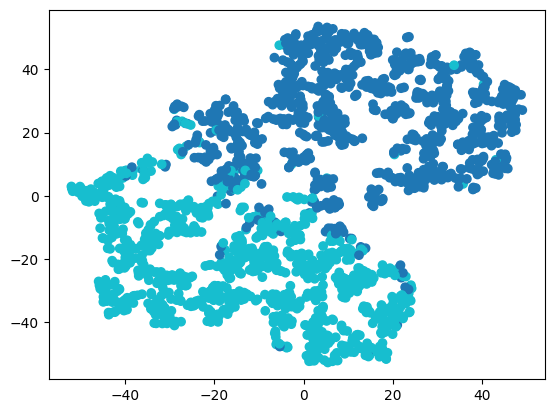

In [259]:
s = plt.scatter(E[:,0], E[:,1], c=Y, cmap='tab10')
plt.grid(False)
plt.set_title(f'Latest Epoch')
plt.axis('equal')


In [261]:
from sklearn.cluster import KMeans

In [265]:
kmeans

KMeans(n_clusters=2, random_state=0)

array([[-13.476266, -20.090002],
       [ 16.173258,  26.97343 ]], dtype=float32)

tensor([[25.0948,  0.0000],
        [ 0.0000, 25.0948]])